In [31]:
from ultralytics import YOLO
import cv2
import math
import matplotlib.pyplot as plt
import pytesseract
import easyocr

In [ ]:
# Cargar modelo
model = YOLO('yolov8n.yaml') # Construir nuevo modelo desde yaml

results = model.train(data='license_plates_dataset/data.yaml', epochs=20, imgsz=640, patience=20)



0: 640x640 1 License-Plates, 156.7ms
Speed: 8.2ms preprocess, 156.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Confidence ---> 0.68
Class name --> matricula


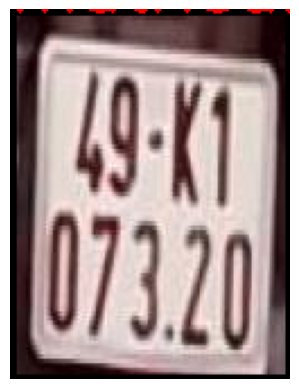

In [37]:
bestModel = YOLO('runs/detect/train4/weights/best.pt')
classNames = ['matricula'] 

image_path = 'media/imagetest3.jpg'
img = cv2.imread(image_path)


img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = bestModel(img, stream=True)

for r in results:
    boxes = r.boxes

    for box in boxes:
        # Contenedor
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # convert to int values
        
        # Recorta la imagen solo con la matricula
        roi = img[y1:y2, x1:x2]

        # Confianza
        confidence = math.ceil((box.conf[0]*100))/100
        print("Confidence --->",confidence)           

        # Clase
        cls = int(box.cls[0])
        print("Class name -->", classNames[cls])

        # Convierte identificador numérico de clase a un color RGB
        escala = int((cls / len(classNames)) * 255 * 3)
        if escala >= 255*2:
            R = 255
            G = 255
            B = escala - 255*2
        else:
            if escala >= 255:
                R = 255
                G = escala - 255
                B = 0
            else:
                R = escala
                G = 0
                B = 0

        # Dibuja el contenedor y clase
        cv2.rectangle(img, (x1, y1), (x2, y2), (R, G, B), 3)
        cv2.putText(img, classNames[cls] , [x1, y1], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, B), 2)

plt.axis("off")
plt.imshow(roi) 
plt.show()



In [ ]:
bestModel = YOLO('runs/detect/train4/weights/best.pt')
classNames = ['matricula'] 

video_path = 'media/videotest.mp4'
cap = cv2.VideoCapture(video_path)

while cap.isOpened():

    ret, frame = cap.read()

    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Apply YOLO model to the frame
    results = bestModel(frame, stream=True)

    for r in results:
        boxes = r.boxes

        for box in boxes:
            # Contenedor
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)  # convert to int value

            # Confianza
            confidence = math.ceil((box.conf[0] * 100)) / 100
            print("Confidence --->", confidence)

            # Clase
            cls = int(box.cls[0])
            print("Class name -->", classNames[cls])

            # Convierte identificador numérico de clase a un color RGB
            escala = int((cls / len(classNames)) * 255 * 3)
            if escala >= 255 * 2:
                R = 255
                G = 255
                B = escala - 255 * 2
            else:
                if escala >= 255:
                    R = 255
                    G = escala - 255
                    B = 0
                else:
                    R = escala
                    G = 0
                    B = 0

            # Dibuja el contenedor y clase
            cv2.rectangle(frame, (x1, y1), (x2, y2), (R, G, B), 3)
            cv2.putText(frame, classNames[cls], [x1, y1], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, B), 2)

    # Show the frame
    cv2.imshow('YOLO Result', frame)

    # Press 'q' to exit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close all windows
cap.release()
cv2.destroyAllWindows()

['eng', 'osd']


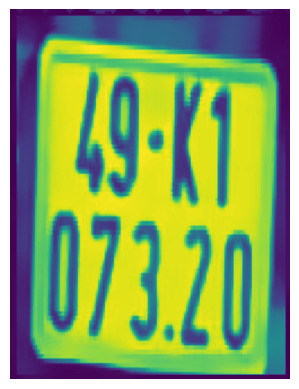

In [52]:
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'

# Lenguajes disponibles
print(pytesseract.get_languages(config=''))

#Cargo imagen y ocnvierto a RGB
roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
gray_image = cv2.bilateralFilter(gray_image, 11, 17, 17)
canny_edge = cv2.Canny(gray_image, 100, 200)

contours, hierarchy = cv2.findContours(canny_edge.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]

# # Initialize license Plate contour and x,y coordinates
contour_with_license_plate = None
license_plate = None
x = None
y = None
w = None
h = None

# Find the contour with 4 potential corners and create a Region of Interest around it
for contour in contours:
    # Find Perimeter of contour and it should be a closed contour
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
    # This checks if it's a rectangle
    if len(approx) == 4:
        contour_with_license_plate = approx
        x, y, w, h = cv2.boundingRect(contour)
        license_plate = gray_image[y:y + h, x:x + w]
        break

plt.axis("off")
plt.imshow(gray_image) 
plt.show()


#Aplica reconocedor a imagen cargada
print(pytesseract.image_to_string(gray_image))

In [34]:
#Carga del modelo de lengua
reader = easyocr.Reader(['en']) 

#Reconocimiento de una imagen
result = reader.readtext(roi)
print(result)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete[([[43, 20], [428, 20], [428, 96], [43, 96]], 'K~NHZODV2366', 0.1527119637993405)]
